In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from math import sqrt
import datetime
import plotly.graph_objects as go
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV
import xgboost as xgb

import shap

We've now built our dataset in Data_prep, we can start focusing on analysis.

In [2]:
# read in the full data df
dtypes = {'start_station_id': str, 'end_station_id': str}

full_data = pd.read_csv('data/2023-citibike-full-data.csv', parse_dates=['started_at', 'ended_at'], dtype=dtypes)
# read in the daily data df
daily_data = pd.read_csv('data/2023-citibike-tripdata-daily-counts.csv', parse_dates=['datetime'])


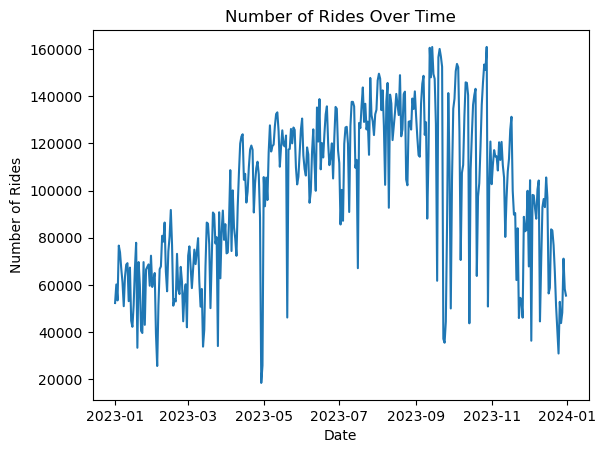

In [4]:
# now we can start to do some analysis
# we'll start with the daily data to get a baseline understanding of the data
# we'll start by looking at how the number of trips changes over our year of interest

# first we'll plot the number of trips over time
fig, ax = plt.subplots()
ax.plot(daily_data['datetime'], daily_data['total_rides'])
ax.set_title('Number of Rides Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Rides')
plt.show()

We see that there is definitely some trend in the data with number of rides dropping significantly in winter months, and with considerable variation day to day.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# we can now try to fit a model to this data to see if we can predict the number of rides
# we'll start with a simple linear regression model
# starting with a slightly more limited set of features
# print out the columns to see what we have to work with
print(daily_data.columns)
# convert the datetime values to a float so that we can use them in the model
daily_data['datetime'] = daily_data['datetime'].astype(int)


features = ['datetime', 'temp', 'feelslike', 'dew',
       'humidity', 'visibility', 'cloudcover', 'windspeed',
       'precip', 'SIR', 'Bridges_Tunnels', 'Access_A_Ride',
       'Metro_North', 'LIRR', 'Buses', 'Subways', 'weekday', 'holiday',
       'month', 'precip_d', 'cold_d', 'hot_d', 'Bridges_Tunnels_d',
       'Access_A_Ride_d', 'Metro_North_d', 'LIRR_d', 'Buses_d', 'Subways_d']
target = 'total_rides'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(daily_data[features], daily_data[target], test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = model.predict(X_test)

# Calculate the root mean squared error
rmse = sqrt(np.mean((y_pred - y_test) ** 2))
print('Root Mean Squared Error:', rmse)

# take a look at the coefficients
coefficients = pd.DataFrame({'feature': X_train.columns, 'coefficient': model.coef_})
print(coefficients)


Index(['Unnamed: 0', 'total_rides', 'datetime', 'temp', 'feelslike', 'dew',
       'humidity', 'conditions', 'visibility', 'cloudcover', 'windspeed',
       'precip', 'SIR', 'Bridges_Tunnels', 'Access_A_Ride', 'Metro_North',
       'LIRR', 'Buses', 'Subways', 'weekday', 'holiday', 'precip_d', 'cold_d',
       'hot_d', 'Bridges_Tunnels_d', 'Access_A_Ride_d', 'Metro_North_d',
       'LIRR_d', 'Buses_d', 'Subways_d', 'month'],
      dtype='object')
Root Mean Squared Error: 12618.397197545097
              feature   coefficient
0            datetime  7.921534e-13
1                temp  5.159262e+02
2           feelslike  6.081738e+02
3                 dew  3.054195e+02
4            humidity -3.897303e+02
5          visibility  2.621809e+01
6          cloudcover -1.019202e+02
7           windspeed -2.089819e+02
8              precip -3.159808e+00
9                 SIR  5.027415e-01
10    Bridges_Tunnels  1.174919e-01
11      Access_A_Ride -9.242167e-01
12        Metro_North  2.048612e-01
13

In [10]:
# we can now try addressing our larger dataset with rides for every day
# here instead of total rides we'll try to predict the duration of the rides
# we'll start with a simple linear regression model
# starting with a slightly more limited set of features

# convert the datetime values to a float so that we can use them in the model
full_data['started_at'] = full_data['started_at'].astype(int)

features = ['started_at', 
       'temp', 'feelslike', 'dew', 'humidity', 
       'weekday', 'holiday', 'month',
       'precip_d', 'cold_d', 'hot_d', 'night', 'station0', 'station1',
       'station2', 'station3', 'station4', 'station5', 'member', 'electric',
       'Bridges_Tunnels_d', 'Access_A_Ride_d', 'Metro_North_d', 'LIRR_d',
       'Buses_d', 'Subways_d', 'precip', 'SIR', 'Bridges_Tunnels', 'Access_A_Ride', 'Metro_North',
       'LIRR', 'Buses', 'Subways']
target = 'ride_duration'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_data[features], full_data[target], test_size=0.2, random_state=42)

# Create and fit the linear regression model
duration_model = LinearRegression()
duration_model.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = duration_model.predict(X_test)

# Calculate the root mean squared error
rmse = sqrt(np.mean((y_pred - y_test) ** 2))
print('Root Mean Squared Error:', rmse)

# take a look at the coefficients
coefficients = pd.DataFrame({'feature': X_train.columns, 'coefficient': duration_model.coef_})
print(coefficients)


Root Mean Squared Error: 1688.3476096274467
              feature   coefficient
0          started_at  2.366650e-15
1                temp  1.610188e+00
2           feelslike  1.781697e+00
3                 dew  7.564669e-01
4            humidity -1.519611e+00
5             weekday  2.849211e-03
6             holiday -3.599721e-03
7               month -6.073056e-02
8            precip_d  9.947640e-04
9              cold_d -1.190683e-02
10              hot_d  0.000000e+00
11              night -2.014070e-05
12           station0  8.910812e-04
13           station1 -5.052581e-04
14           station2 -5.327824e-04
15           station3  4.412854e-04
16           station4 -4.231302e-05
17           station5 -2.520132e-04
18             member -2.490017e-03
19           electric  6.290726e-04
20  Bridges_Tunnels_d -6.060204e-04
21    Access_A_Ride_d -2.836776e-03
22      Metro_North_d  1.883186e-03
23             LIRR_d  8.533790e-04
24            Buses_d  8.249659e-04
25          Subways_

In [48]:
# let's try a random forest model to see if we can get a better performance
# Create and fit the random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and calculate RMSE
y_pred_rf = rf_model.predict(X_test)
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))

print('Root Mean Squared Error:', rmse_rf)

Root Mean Squared Error: 1935.3660447926861


The Random Forest approach seems to perform a little bit worse. Let's try introducing slightly more complexity to our feature space and then giving lasso regression a try.

In [7]:
# trying a lasso regression model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_data[features], full_data[target], test_size=0.2, random_state=42)

# Create and fit the lasso regression model
# search over alpha values to find the best one
alpha = 0.1
lasso_cv = LassoCV(alphas=[alpha], cv=5, random_state=42, max_iter=10000, tol=0.0001)
lasso_cv.fit(X_train, y_train)

# Predict and calculate RMSE
y_pred_lasso = lasso_cv.predict(X_test)
rmse_lasso = sqrt(mean_squared_error(y_test, y_pred_lasso))

print('Root Mean Squared Error:', rmse_lasso)

Root Mean Squared Error: 1675.5221652724122


/Users/fordshaper/miniforge3/envs/cs1430/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e+12, tolerance: 3.955e+08
  model = cd_fast.enet_coordinate_descent(


In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 6,  # maximum depth of a tree
    'eta': 0.3,  # the learning rate
    'objective': 'reg:squarederror',  # regression task with squared loss
    'eval_metric': 'rmse',  # using RMSE as the evaluation metric
}
num_boost_round = 100  # number of trees to build

bst = xgb.train(params, dtrain, num_boost_round, evals=[(dtest, 'test')], early_stopping_rounds=10)

y_pred = bst.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))


[0]	test-rmse:1682.48091
[1]	test-rmse:1678.42283
[2]	test-rmse:1676.32829
[3]	test-rmse:1675.35251
[4]	test-rmse:1674.80374
[5]	test-rmse:1674.51378
[6]	test-rmse:1674.33133
[7]	test-rmse:1674.29807
[8]	test-rmse:1674.25572
[9]	test-rmse:1674.19612
[10]	test-rmse:1674.20194
[11]	test-rmse:1674.16914
[12]	test-rmse:1674.16547
[13]	test-rmse:1674.24304
[14]	test-rmse:1674.22551
[15]	test-rmse:1674.22603
[16]	test-rmse:1674.26512
[17]	test-rmse:1674.24273
[18]	test-rmse:1674.23750
[19]	test-rmse:1674.23578
[20]	test-rmse:1674.29093
[21]	test-rmse:1674.32546
[22]	test-rmse:1674.34628
RMSE: 1674.346270


In [11]:
# lets try using the built in cross validation to see if we can get a better model
params = {'max_depth':3, 'eta':0.1, 'objective':'reg:squarederror', 'eval_metric':'rmse'}
cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=3, num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=42)

print(cv_results)


    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0       1677.981241       15.835488     1677.780039      31.448925
1       1675.682567       15.857144     1675.480323      31.493316
2       1673.806594       15.872637     1673.619819      31.525403
3       1672.268590       15.887763     1672.087106      31.558255
4       1671.004047       15.896283     1670.825013      31.581678
5       1669.958819       15.900876     1669.795569      31.601660
6       1669.104603       15.907197     1668.947371      31.628602
7       1668.390848       15.908951     1668.248101      31.644247
8       1667.802801       15.916240     1667.675940      31.649284
9       1667.312888       15.916839     1667.192930      31.660284
10      1666.898295       15.917951     1666.785589      31.669055
11      1666.555194       15.918662     1666.459274      31.674517
12      1666.264590       15.917576     1666.173666      31.680368
13      1666.023507       15.916227     1665.943960      31.68

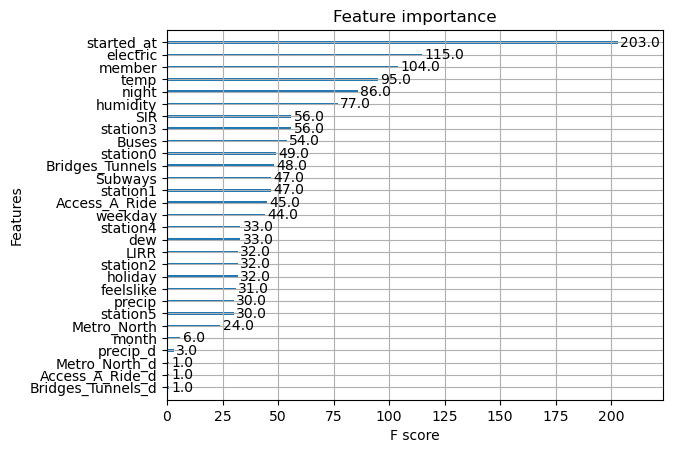

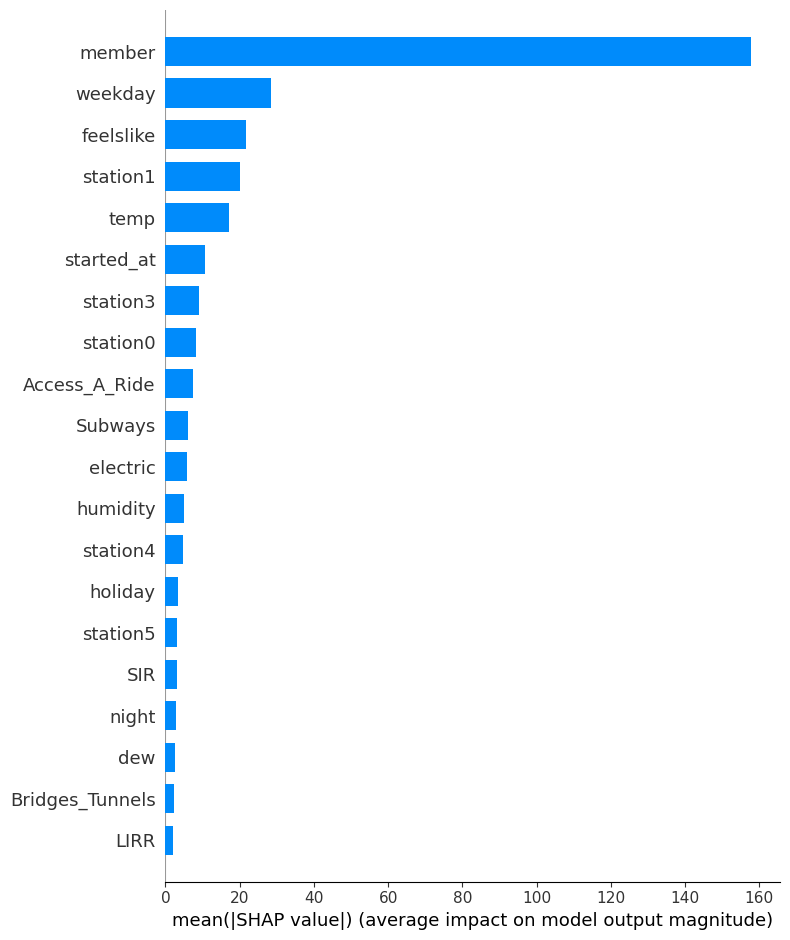

In [16]:
# now that we have a model that we're happy with lets take a look at the feature importance

xgb.plot_importance(bst)
plt.show()

# Calculate SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

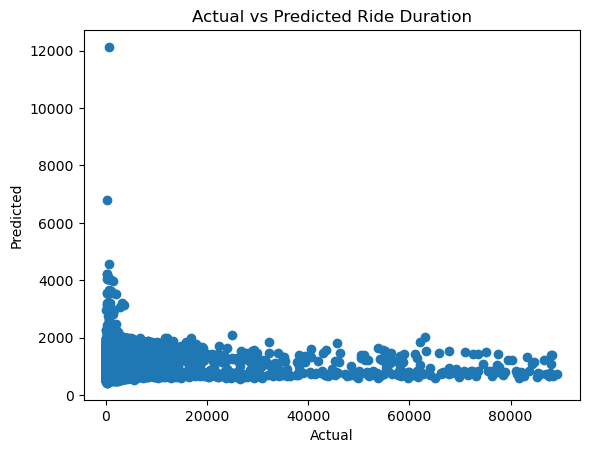

In [22]:
# lets take a look at the actual vs predicted values
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)

ax.set_title('Actual vs Predicted Ride Duration')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()



